In [44]:
"""
Problem exposed regarding the sequencing of a graph of computation
- we have a graph of tasks to be performed
- each task can schedule other tasks that needs to be done first to complete the task
- each task has a key, and we want to remember its result (cause it can be shared)
- we want to execute the tasks that can be executed now in parallel
"""

from abc import *
from collections import *
from dataclasses import *
from typing import *


@dataclass(frozen=False)
class TaskResult:
    answer: Any
    dependencies: List[Any] # TODO - should be task, but no recursively defined types allowed

        
class Task(ABC):
    
    @abstractmethod
    def key(self) -> Any:
        pass
    
    @abstractmethod
    def execute(self, environment: Dict[Any, Any]) -> TaskResult:
        pass

    def __repr__(self):
        return self.key()    

    
@dataclass(frozen=False)
class BlockedTask:
    task: Task
    children_keys: Set[Any]

    
def schedule(top_level_tasks: List[Any], environment: Dict[Any, Any]):
    """
    @param top_level_tasks the tasks we are interested in
    @param environnement the value of variables needed
    """
    
    ready = deque(top_level_tasks)
    parent_keys = {t.key(): set() for t in top_level_tasks}
    blocked = {}
    results = dict(environment)
    
    while ready:        
        task = ready.popleft()
        result = task.execute(results)
        # To execute by batch, just consume all results here...
        if result.answer:
            key = task.key()
            results[key] = result.answer
            for parent_key in parent_keys[key]:
                parent = blocked[parent_key]
                parent.children_keys.remove(key)
                if not parent.children_keys:
                    del blocked[parent_key]
                    ready.append(parent.task)
            del parent_keys[key]
        else:
            for child in result.dependencies:
                if child.key() not in parent_keys:
                    ready.append(child)
                    parent_keys[child.key()] = set()
                parent_keys[child.key()].add(task.key())
            blocked[task.key()] = BlockedTask(task=task, children_keys=set(t.key() for t in result.dependencies))
    
    return [results[t.key()] for t in top_level_tasks]

In [49]:
"""
Test case with Mathematical functions
"""

import math

class Variable(Task):
    def __init__(self, variable_name):
        self.variable_name = variable_name
        
    def key(self):
        return self.variable_name
    
    def execute(self, environment: Dict[Any, Any]):
        return TaskResult(answer=environment[self.variable_name], dependencies=[])

class Exp(Task):
    def __init__(self, wrapped):
        self.wrapped = wrapped
    
    def key(self):
        return "exp(" +  self.wrapped.key() + ")"
    
    def execute(self, environment: Dict[Any, Any]):
        if self.wrapped.key() in environment:
            x = environment[self.wrapped.key()]
            return TaskResult(answer=math.exp(x), dependencies=[])
        else:
            return TaskResult(answer=None, dependencies=[self.wrapped])

class Minus(Task):
    def __init__(self, wrapped):
        self.wrapped = wrapped
        
    def key(self):
        return "-" + self.wrapped.key()
    
    def execute(self, environment: Dict[Any, Any]):
        if self.wrapped.key() in environment:
            x = environment[self.wrapped.key()]
            return TaskResult(answer=-x, dependencies=[])
        else:
            return TaskResult(answer=None, dependencies=[self.wrapped])
            
class TanHyperbolic(Task):
    def __init__(self, wrapped):
        self.wrapped = wrapped
    
    def key(self):
        return "tanh(" + self.wrapped.key() + ")"
    
    def execute(self, environment: Dict[Any, Any]):
        dep1 = Exp(self.wrapped)
        dep2 = Exp(Minus(self.wrapped))
        if dep1.key() in environment and dep2.key() in environment:
            ex = environment[dep1.key()]
            emx = environment[dep2.key()]
            return TaskResult(answer=(ex - emx) / (ex + emx), dependencies=[])
        else:
            return TaskResult(answer=None, dependencies=[dep1, dep2])
        
class Logistic(Task):
    def __init__(self, wrapped):
        self.wrapped = wrapped
        
    def key(self):
        return "logistic(" + self.wrapped.key() + ")"
    
    def execute(self, environment: Dict[Any, Any]):
        dep = Exp(self.wrapped)
        if dep.key() in environment:
            ex = environment[dep.key()]
            return TaskResult(answer= ex / (1 + ex), dependencies=[])
        else:
            return TaskResult(answer=None, dependencies=[dep])


results = schedule(top_level_tasks=[Logistic(Variable("x")),
                                    TanHyperbolic(Variable("x")),
                                    TanHyperbolic(Variable("y"))],
                   environment={"x": 1, "y": -1})
print(results)

[0.7310585786300049, 0.7615941559557649, -0.7615941559557649]


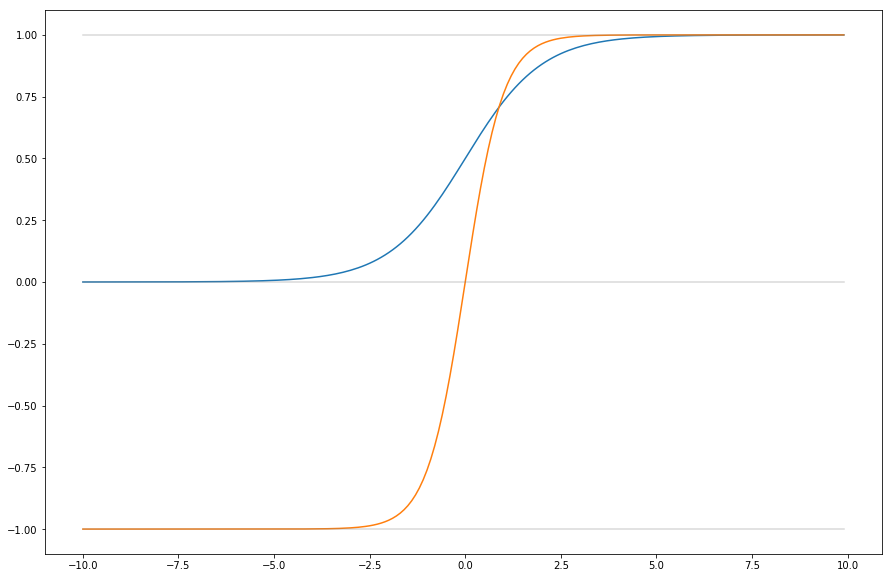

In [67]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

xs = np.arange(-10, 10, 0.1)
ys1 = []
ys2 = []

for x in xs:
    y = schedule(top_level_tasks=[Logistic(Variable("x")), TanHyperbolic(Variable("x"))], environment={"x": x})
    ys1.append(y[0])
    ys2.append(y[1])

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(xs, np.array(ys1))
ax.plot(xs, np.array(ys2))
ax.plot(xs, [0] * len(xs), color='gray', alpha=0.3)
ax.plot(xs, [1] * len(xs), color='gray', alpha=0.3)
ax.plot(xs, [-1] * len(xs), color='gray', alpha=0.3)
plt.show()